## 1. Gather(Update) Data

The following functions gathers and updates data from site

In [62]:
import os
import tarfile
import re
import shutil
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URLS = [DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2", DOWNLOAD_ROOT + "20030228_easy_ham_2.tar.bz2"]
SPAM_URLS = [DOWNLOAD_ROOT + "20030228_spam.tar.bz2", DOWNLOAD_ROOT + "20050311_spam_2.tar.bz2"]
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_urls, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    pattern = re.compile("(ham|spam)(_2)?(.tar.bz2)")
    for url in spam_urls:
        m = pattern.search(url)
        file_name = "".join([p for p in m.groups() if p])
        file_path = os.path.join(spam_path, file_name)
        try:
            urllib.request.urlretrieve(url, file_path)
        except:
            pass
        if os.path.isfile(file_path):
            tar_bz2_file = tarfile.open(file_path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
        else:
            raise "Tar_file_{}_not_found".format(file_name)

In [58]:
fetch_spam_data(SPAM_URLS + HAM_URLS)

Moves data to datasets/spam/all_spam and datasets/spam/all_ham

In [70]:
SPAM_DIRS = [os.path.join(SPAM_PATH, i) for i in ["spam", "spam_2"]]
HAM_DIRS = [os.path.join(SPAM_PATH, i) for i in ["easy_ham", "easy_ham_2"]]
SPAM_DEST = os.path.join(SPAM_PATH, "all_spam")
HAM_DEST = os.path.join(SPAM_PATH, "all_ham")

def move_data(dest, *sources):
    if not os.path.isdir(dest):
        os.makedirs(dest)
    for source in sources:
        if not os.path.isdir(source):
            print("Warning: source_dir {} not found".format(source))
            continue
        for root, dirs, files in os.walk(source):
            for file in files:
                shutil.move(os.path.join(root, file), os.path.join(dest, file))

In [71]:
move_data(HAM_DEST, *HAM_DIRS)
move_data(SPAM_DEST, *SPAM_DIRS)

## 2.Analysing Data

First We check the ratio of data to see if there are problems with positive and negative ratio

In [81]:
# Data with name length < 20 is not legit according to document
ham_filenames = [name for name in sorted(os.listdir(HAM_DEST)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DEST)) if len(name) > 20]

print("len(spam_filenames):", len(spam_filenames))
print("len(ham_filenames):", len(ham_filenames))
print("spam_ham_ratio:{}/{} or\n\t       {}".format(1,
                                        len(ham_filenames)/len(spam_filenames), 
                                        len(spam_filenames)/len(ham_filenames)))

len(spam_filenames): 1896
len(ham_filenames): 3900
spam_ham_ratio:1/2.0569620253164556 or
	       0.48615384615384616


Then we load some smaple emails
NOTE: the email structure is 
<pre>[
 header,
 payload(multipart/non_multipart)[(Only When multipart)
                                  part1,
                                  part2,
                                  ...,
                                 ]
]</pre>

In [83]:
import email
import email.policy


def load_email(file_path, file_name):
    with open(os.path.join(file_path, file_name), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [87]:
ham_emails = [load_email(HAM_DEST, file_name) for file_name in ham_filenames]
spam_emails = [load_email(SPAM_DEST, file_name) for file_name in spam_filenames]

In [233]:
print(ham_emails[1].get_content())

    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55

In [120]:
print(ham_emails[2].get_payload()[0].get_content_type())

text/plain


In [121]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()


def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [123]:
ham_structures = structures_counter(ham_emails)
spam_structures = structures_counter(spam_emails)

In [128]:
ham_structures.most_common()

[('text/plain', 3751),
 ('multipart(text/plain, application/pgp-signature)', 101),
 ('multipart(text/plain, text/html)', 20),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 2),
 ('multipart(text/plain, multipart(text/plain))', 2),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('text/html', 2),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/x-patch)', 1),
 ('multipart(multipart(text/plain, multipart(text/plain), text/plain), application/pgp-signature)',
  1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/gif, image/gif, image/gif, image/gif)',
  1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, application/ms-tnef)', 1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(

In [129]:
spam_structures.most_common()

[('text/plain', 815),
 ('text/html', 772),
 ('multipart(text/plain, text/html)', 159),
 ('multipart(text/html)', 49),
 ('multipart(text/plain)', 44),
 ('multipart(multipart(text/html))', 23),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 3),
 ('multipart(text/html, text/plain)', 3),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart/alternative', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/gif)',
  1),
 ('text/plain charset=us-ascii', 1),
 ('multipart(multipart(text

In [131]:
for header, value in ham_emails[0].items():
    print(header,":",value)

Return-Path : <exmh-workers-admin@spamassassin.taint.org>
Delivered-To : yyyy@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34	for <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)
Received : from phobos [127.0.0.1]	by localhost with IMAP (fetchmail-5.9.0)	for jm@localhost (single-drop); Wed, 21 Aug 2002 13:33:03 +0100 (IST)
Received : from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7LCXvZ24654 for    <jm-exmh@jmason.org>; Wed, 21 Aug 2002 13:33:57 +0100
Received : from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by    listman.redhat.com (Postfix) with ESMTP id F12A13EA25; Wed, 21 Aug 2002    08:34:00 -0400 (EDT)
Delivered-To : exmh-workers@listman.spamassassin.taint.org
Received : from int-mx1.corp.spamassassin.taint.org (int-mx1.corp.spamassassin.taint.org    [172.16.52.254]

In [130]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <ilug-admin@linux.ie>
Delivered-To : yyyy@localhost.netnoteinc.com
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 9E1F5441DD	for <jm@localhost>; Tue,  6 Aug 2002 06:48:09 -0400 (EDT)
Received : from phobos [127.0.0.1]	by localhost with IMAP (fetchmail-5.9.0)	for jm@localhost (single-drop); Tue, 06 Aug 2002 11:48:09 +0100 (IST)
Received : from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g72LqWv13294 for    <jm-ilug@jmason.org>; Fri, 2 Aug 2002 22:52:32 +0100
Received : from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org    (8.9.3/8.9.3) with ESMTP id WAA31224; Fri, 2 Aug 2002 22:50:17 +0100
Received : from bettyjagessar.com (w142.z064000057.nyc-ny.dsl.cnc.net    [64.0.57.142]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id WAA31201 for    <ilug@linux.ie>; Fri, 2 Aug 2002 22:50:11 +0100
X-Authentication-Warning : lugh.tuatha.org: Host w142.z0640

In [134]:
spam_emails[1]["Subject"]

'Life Insurance - Why Pay More?'

### Split to train test set

In [309]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

X = np.array(spam_emails + ham_emails)
y = np.array([1] * len(spam_emails) + [0] * len(ham_emails))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train_f, X_test_f = X[train_index], X[test_index]
    y_train_f, y_test_f = y[train_index], y[test_index]

### Dealing with html with Re!!

In [146]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

### Convert email to string

This is an improved version based on:
    <a herf="https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb">https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb</a>

In [150]:
def email_to_text(email):
    html = None
    contents = ""
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            contents += (" " + content)
        else:
            contents += (" " + html_to_plain_text(content))
    return contents

In [169]:
count = 0
for ind in range(len(spam_emails)):
    sample_email = spam_emails[ind]
#     print(type(get_email_structure(sample_email)))
    if not "multi" in get_email_structure(sample_email):
        continue
    else:
        count += 1
        print("=================================")
        print(ind)
        print(get_email_structure(sample_email))
        print(email_to_text(spam_emails[9]))
        if count > 5:
            break

17
multipart(text/plain, application/octet-stream, text/plain)
 
Government Grants E-Book 2002
edition, Just $15.95. Summer Sale, Good Until August 10, 2002!  Was $49.95.
You Can Receive The Money You Need...
Every day millions of
dollars are given away to people, just like
you!!
Your Government spends billions of tax dollars on
government grants.
Do you know that private foundations, trust and
corporations are
required to give away a portion of theirs assets.
It doesn't matter,
where you live (USA ONLY), your employment status,
or if you are broke, retired
or living on a fixed income. There may be a grant
for you!
ANYONE can apply
for a Grant from 18 years old and up!
We will show you HOW & WHERE to get Grants. THIS BOOK IS NEWLY UPDATED WITH THE
MOST CURRENT INFORMATION!!!
Grants from $500.00 to $50,000.00 are possible!
GRANTS don't have to be paid back, EVER!
Grants can be ideal for people who are or were
bankrupt or just have bad credit.
Please Visit Our
Website
And Place Your  Ord

### Some necessary toolkit for processing

In [147]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [199]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


## Start To build pipeline

### 1.Convert Email to word count

In [202]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        
    def fit(self, X_train, y_train=None):
        return self
    
    def transform(self, X_train, y_train=None):
        X_transformed = []
        for email in X_train:
            text = email_to_text(email)
            if self.strip_headers:
                pass
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                urls = list(set(urlextract.URLExtract().find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [204]:
email_to_word_counter_transformer = EmailToWordCounterTransformer()

In [205]:
X_train_wc = email_to_word_counter_transformer.fit_transform(X_train)
X_train_wc

array([ Counter({'key': 18, 'the': 16, 'a': 14, 'person': 9, 'to': 8, 'of': 8, 'your': 7, 'list': 7, 'url': 7, 'you': 6, 'id': 5, 'and': 5, 'from': 5, 'copi': 5, 'it': 5, 'b': 5, 'name': 4, 'will': 4, 'is': 4, 'can': 4, 'then': 4, 'on': 4, 'pgp': 3, 'type': 3, 'size': 3, 'fingerprint': 3, 'master': 3, 'their': 3, 'that': 3, 'owner': 3, 'check': 3, 'number': 3, 'in': 2, 'gpg': 2, 'sign': 2, 'get': 2, 'email': 2, 'me': 2, 'info': 2, 'i': 2, 'add': 2, 'if': 2, 'now': 2, 'out': 2, 'photo': 2, 'ident': 2, 'send': 2, 'valid': 2, 'thi': 2, 'match': 2, 'for': 2, 'off': 2, 's': 2, 'mark': 2, 'fnumber': 2, 'spamassassin': 2, 'sight': 2, 'anyon': 1, 'interest': 1, 'togeth': 1, 'dc': 1, 'pleas': 1, 'don': 1, 't': 1, 'have': 1, 'great': 1, 'time': 1, 'make': 1, 'one': 1, 'want': 1, 'find': 1, 'more': 1, 'about': 1, 'softwar': 1, 'pgpfreewar': 1, 'gnupg': 1, 'bring': 1, 'follow': 1, 'must': 1, 'be': 1, 'print': 1, 'pass': 1, 'what': 1, 'peopl': 1, 'individu': 1, 'we': 1, 'cross': 1, 'eachoth': 1, 'w

### 2.Convert word count to vector

In [228]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, with_min=True, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
        self.with_min = with_min
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                if self.with_min:
                    total_count[word] += min(count, 10)
                else:
                    total_count[word] += count
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [229]:
word_counter_to_vector_transformer = WordCounterToVectorTransformer()

In [230]:
X_train_vec = word_counter_to_vector_transformer.fit_transform(X_train_wc)
X_train_vec

<4636x1001 sparse matrix of type '<class 'numpy.int64'>'
	with 397649 stored elements in Compressed Sparse Row format>

## Now we Set up the pipline and train the classifier

The following fragment was modified from:<br/>
    https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

In [236]:
data_prep_pip = Pipeline([
    ("email_to_word_counter", EmailToWordCounterTransformer()),
    ("word_counter_to_vector", WordCounterToVectorTransformer()),
])

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, FeatureUnion


classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols_acc = ["Classifier", "Accuracy"]
log_cols_prec = ["Classifier", "Precision"]
log_cols_rec = ["Classifier", "Recall"]
log_cols_f1 = ["Classifier", "F1"]
log_acc      = pd.DataFrame(columns=log_cols_acc)
log_prec      = pd.DataFrame(columns=log_cols_prec)
log_rec      = pd.DataFrame(columns=log_cols_rec)
log_f1      = pd.DataFrame(columns=log_cols_f1)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)


prec_dict = dict()
rec_dict = dict()
acc_dict = dict()
f1_dict = dict()

X_prep = data_prep_pip.fit_transform(X).toarray()

for train_index, test_index in sss.split(X_prep, y):
    X_train, X_test = X_prep[train_index], X_prep[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        prec = precision_score(y_test, train_predictions)
        rec = recall_score(y_test, train_predictions)
        f1 = f1_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc
            
        if name in prec_dict:
            prec_dict[name] += prec
        else:
            prec_dict[name] = prec
            
        if name in rec_dict:
            rec_dict[name] += rec
        else:
            rec_dict[name] = rec
            
        if name in f1_dict:
            f1_dict[name] += f1
        else:
            f1_dict[name] = f1

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry_acc = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols_acc)
    log_acc = log_acc.append(log_entry_acc)
    
for clf in prec_dict:
    prec_dict[clf] = prec_dict[clf] / 10.0
    log_entry_prec = pd.DataFrame([[clf, prec_dict[clf]]], columns=log_cols_prec)
    log_prec = log_prec.append(log_entry_prec)

for clf in rec_dict:
    rec_dict[clf] = rec_dict[clf] / 10.0
    log_entry_rec = pd.DataFrame([[clf, rec_dict[clf]]], columns=log_cols_rec)
    log_rec = log_rec.append(log_entry_rec)
    
for clf in f1_dict:
    f1_dict[clf] = f1_dict[clf] / 10.0
    log_entry_f1 = pd.DataFrame([[clf, f1_dict[clf]]], columns=log_cols_f1)
    log_f1 = log_f1.append(log_entry_f1)

/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analy

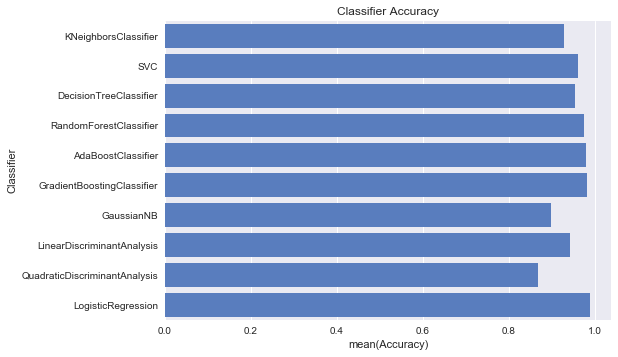

In [252]:
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log_acc, color="b")

plt.show()

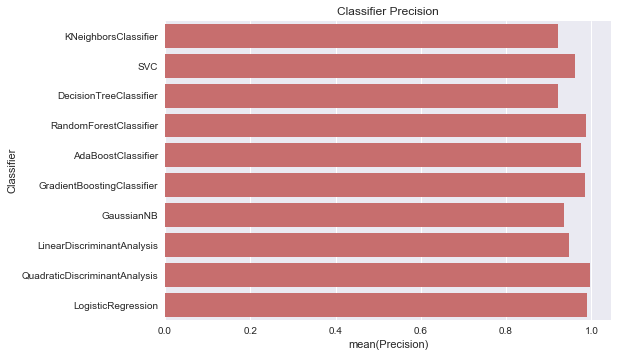

In [253]:
plt.xlabel('Precision')
plt.title('Classifier Precision')

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log_prec, color="r")

plt.show()

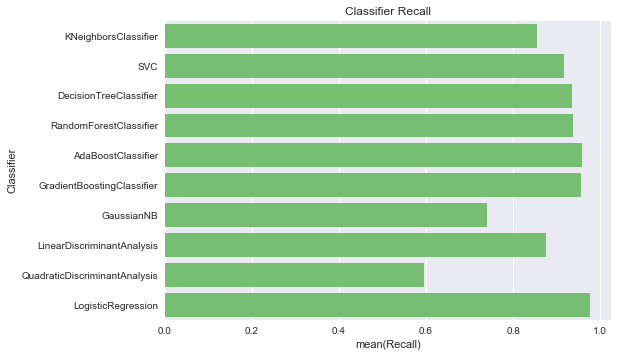

In [254]:
plt.xlabel('Recall')
plt.title('Classifier Recall')

sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log_rec, color="g")

plt.show()

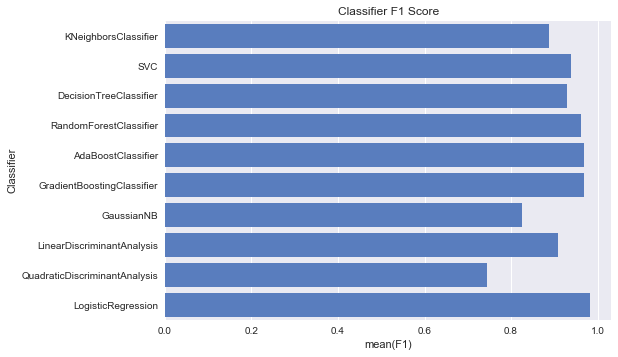

In [255]:
plt.xlabel('F1')
plt.title('Classifier F1 Score')

sns.set_color_codes("muted")
sns.barplot(x='F1', y='Classifier', data=log_f1, color="b")

plt.show()

In [275]:
rank_clfs = list(f1_dict.items())
rank_clfs.sort(key=lambda x: x[1], reverse=True)
print(rank_clfs)
best_clf = rank_clfs[0][0]
best_clf

[('LogisticRegression', 0.98260060394959292), ('GradientBoostingClassifier', 0.96960299569620056), ('AdaBoostClassifier', 0.96748031215378438), ('RandomForestClassifier', 0.96171186529138597), ('SVC', 0.93887948118048592), ('DecisionTreeClassifier', 0.92866538414083344), ('LinearDiscriminantAnalysis', 0.90934568464139853), ('KNeighborsClassifier', 0.88674043680918135), ('GaussianNB', 0.82507541143463548), ('QuadraticDiscriminantAnalysis', 0.74515864545131638)]


'LogisticRegression'

The crude evaluation found out that the best performed model is: <br>
<p><strong>logistic regression</strong></p>

## Evaluate The best model

Let's do a grid RandomizedSearch

In [289]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

from tempfile import mkdtemp

In [288]:
temp_cache = mkdtemp()

full_pipeline = Pipeline(
    [
        ("email_to_word_counter", EmailToWordCounterTransformer()),
        ("word_counter_to_vector", WordCounterToVectorTransformer()),
        ("classifier", eval(best_clf+'()')),
    ],
    memory = temp_cache
)

param_dict = {
    "email_to_word_counter__replace_urls": [True, False],
    "email_to_word_counter__replace_numbers": [True, False],
    "email_to_word_counter__lower_case": [True, False],
    "word_counter_to_vector__with_min": [True, False],
    "word_counter_to_vector__vocabulary_size": [500, 1000, 1500],
    "classifier__class_weight": ["balanced", None],
    "classifier__C": [0.2 * i for i in range(3, 8)],
    "classifier__penalty": ["l1", "l2"],
}

random_logreg_clf = RandomizedSearchCV(full_pipeline, param_dict, verbose=2, n_iter=15)

In [ ]:
random_logreg_clf.fit(X, y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] word_counter_to_vector__with_min=False, word_counter_to_vector__vocabulary_size=1000, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=False, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001 
[CV]  word_counter_to_vector__with_min=False, word_counter_to_vector__vocabulary_size=1000, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=False, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001, total=  53.0s
[CV] word_counter_to_vector__with_min=False, word_counter_to_vector__vocabulary_size=1000, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=False, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  word_counter_to_vector__with_min=False, word_counter_to_vector__vocabulary_size=1000, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=False, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001, total=  44.3s
[CV] word_counter_to_vector__with_min=False, word_counter_to_vector__vocabulary_size=1000, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=False, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001 
[CV]  word_counter_to_vector__with_min=False, word_counter_to_vector__vocabulary_size=1000, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=False, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001, total=  51.5s
[CV] word_counter_to_vector_

[CV]  word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500, email_to_word_counter__replace_urls=True, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=True, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=1.0, total= 4.3min
[CV] word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500, email_to_word_counter__replace_urls=True, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=True, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=1.0 
[CV]  word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500, email_to_word_counter__replace_urls=True, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=True, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=1.0, total= 4.0min
[CV] word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500,

[CV]  word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500, email_to_word_counter__replace_urls=True, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=False, classifier__penalty=l1, classifier__class_weight=None, classifier__C=1.4000000000000001, total= 4.0min
[CV] word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500, email_to_word_counter__replace_urls=True, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=False, classifier__penalty=l1, classifier__class_weight=None, classifier__C=0.6000000000000001 
[CV]  word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=500, email_to_word_counter__replace_urls=True, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=False, classifier__penalty=l1, classifier__class_weight=None, classifier__C=0.6000000000000001, total= 4.0min
[CV] word_counter_to_vector__with_min=True, word_cou

[CV]  word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=1500, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001, total=  45.4s
[CV] word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=1500, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001 
[CV]  word_counter_to_vector__with_min=True, word_counter_to_vector__vocabulary_size=1500, email_to_word_counter__replace_urls=False, email_to_word_counter__replace_numbers=True, email_to_word_counter__lower_case=False, classifier__penalty=l2, classifier__class_weight=balanced, classifier__C=0.6000000000000001, total=  48.4s


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 148.1min finished


RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Pipeline(memory='/var/folders/48/tc68rwf51_b1qwqw5c1glvg80000gn/T/tmpbue6fh48',
     steps=[('email_to_word_counter', EmailToWordCounterTransformer(lower_case=True, remove_punctuation=True,
               replace_numbers=True, replace_urls=True, stemming=True,
               strip_headers=True)), ('word_counter_to_vector', WordCounterToVectorTransformer(vocabulary_size=1000, with_mi...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=15, n_jobs=1,
          param_distributions={'email_to_word_counter__replace_urls': [True, False], 'email_to_word_counter__replace_numbers': [True, False], 'email_to_word_counter__lower_case': [True, False], 'word_counter_to_vector__with_min': [True, False], 'word_counter_to_vector__vocabulary_size': [500, 1000, 1500], 'classifier__class_weight': ['balanced', None], 'classifier__C': [0.6000000

In [307]:
log_reg_clf = random_logreg_clf.best_estimator_
log_reg_clf.steps

[('email_to_word_counter',
  EmailToWordCounterTransformer(lower_case=True, remove_punctuation=True,
                 replace_numbers=True, replace_urls=True, stemming=True,
                 strip_headers=True)),
 ('word_counter_to_vector',
  WordCounterToVectorTransformer(vocabulary_size=1000, with_min=True)),
 ('classifier',
  LogisticRegression(C=1.2000000000000002, class_weight='balanced', dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]

In [308]:
log_reg_clf.named_steps.word_counter_to_vector

WordCounterToVectorTransformer(vocabulary_size=1000, with_min=True)

In [293]:
random_logreg_clf.cv_results_

{'mean_fit_time': array([  38.49516344,   37.08779931,   36.43427134,   35.83759332,
          38.53274139,  171.38246965,   30.02027297,  164.13838243,
         160.5523266 ,  164.80480305,  169.30692196,  160.04292766,
          40.16166369,   37.68837134,   37.61166652]),
 'mean_score_time': array([ 11.09550063,  11.08877929,  11.3279043 ,  10.23337603,
         11.91537197,  75.65578739,  10.5800581 ,  73.47989225,
         73.55742963,  73.88601486,  78.18507298,  73.12453071,
         10.94098711,  10.82392963,  12.53882726]),
 'mean_test_score': array([ 0.97688061,  0.97550035,  0.97377502,  0.97567288,  0.97429262,
         0.97705314,  0.9694617 ,  0.9784334 ,  0.97860594,  0.97187716,
         0.97360248,  0.97688061,  0.97360248,  0.97463768,  0.97584541]),
 'mean_train_score': array([ 0.99965493,  0.99827467,  0.99542788,  0.99767081,  0.99775707,
         0.99465148,  0.99723948,  0.99672188,  0.998706  ,  0.99698068,
         0.99542788,  0.99568668,  0.99672188,  0.99930

In [310]:
from sklearn.metrics import precision_score, recall_score

y_pred = log_reg_clf.fit(X_train_f, y_train_f)
y_pred = log_reg_clf.predict(X_test_f)

print("Precision: {:.2f}%".format(precision_score(y_test_f, y_pred)*100))
print("Recall: {:.2f}%".format(recall_score(y_test_f, y_pred)*100))

Precision: 98.40%
Recall: 97.36%
